In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.stats as stats
# import xgboost as xgb

import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

2024-07-19 10:49:18.606032: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 10:49:18.611303: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 10:49:18.626285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 10:49:18.650146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 10:49:18.657166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 10:49:18.675800: I tensorflow/core/platform/cpu_feature_gu

In [2]:
file_path = "raw_data/Dataset.csv"
df = pd.read_csv(file_path, index_col = 0)
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [3]:
df.Patient_ID.value_counts()

Patient_ID
3658      336
114471    336
101922    336
117406    336
4905      336
         ... 
110085      8
16854       8
118844      8
16161       8
109559      8
Name: count, Length: 40336, dtype: int64

# Clean the Data

## Missing Values

In [4]:
(df.isnull().sum()/len(df)).sort_values(ascending=False)

Bilirubin_direct    0.998074
Fibrinogen          0.993402
TroponinI           0.990477
Bilirubin_total     0.985092
Alkalinephos        0.983932
AST                 0.983776
Lactate             0.973299
PTT                 0.970559
SaO2                0.965494
EtCO2               0.962868
Phosphate           0.959863
HCO3                0.958106
Chloride            0.954603
BaseExcess          0.945790
PaCO2               0.944401
Calcium             0.941161
Platelets           0.940595
Creatinine          0.939044
Magnesium           0.936896
WBC                 0.935932
BUN                 0.931344
pH                  0.930697
Hgb                 0.926176
FiO2                0.916658
Hct                 0.911460
Potassium           0.906891
Glucose             0.828943
Temp                0.661627
Unit1               0.394251
Unit2               0.394251
DBP                 0.313459
Resp                0.153546
SBP                 0.145770
O2Sat               0.130611
MAP           

 ## Dropping Blood Test Features

In [5]:
#features to drop in the dataset

columns_drop = ['EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2']

columns_for_baseline = ['Hour', 'HR','O2Sat', 'Temp','SBP', 'MAP', 'DBP', 'Resp','Age','Gender','Patient_ID','SepsisLabel']

In [6]:
df1 = df[columns_for_baseline]
df1.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,Patient_ID,SepsisLabel
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.54,0,17072,0
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,68.54,0,17072,0
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,68.54,0,17072,0
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,68.54,0,17072,0
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,68.54,0,17072,0


 ## Reducing the number of Patients 

In [7]:
# Filter patient IDs where at some point sepsis label is 1
sepsis_patients_ids = list(set(df1.loc[df1['SepsisLabel'] == 1, 'Patient_ID'].tolist()))
len(sepsis_patients_ids)

2932

In [8]:
# Get unique Patient_IDs from df_encoded
all_patient_ids = set(df1['Patient_ID'])
# Find Patient_IDs not in sepsis_patients_ids
no_sepsis_patients_ids = list(all_patient_ids - set(sepsis_patients_ids))
len(no_sepsis_patients_ids)

37404

In [9]:
non_sepsis_selected_patients_ids = random.sample(no_sepsis_patients_ids, 4000)

In [10]:
non_sepsis_selected_df = df1.loc[df1['Patient_ID'].isin(non_sepsis_selected_patients_ids)]
sepsis_selected_df = df1.loc[df1['Patient_ID'].isin(sepsis_patients_ids)]

In [11]:
final_df = pd.concat([non_sepsis_selected_df,sepsis_selected_df])
final_df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,Patient_ID,SepsisLabel
0,0,88.0,100.0,34.60,114.50,90.0,71.50,10.0,60.42,0,1380,0
1,1,88.0,100.0,34.90,116.00,91.0,75.00,10.0,60.42,0,1380,0
2,2,88.0,100.0,36.05,112.75,85.5,71.50,11.0,60.42,0,1380,0
3,3,88.0,99.5,36.90,113.00,89.5,76.25,12.5,60.42,0,1380,0
4,4,87.0,100.0,37.00,107.50,88.0,77.00,13.0,60.42,0,1380,0


In [12]:
final_df

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,Patient_ID,SepsisLabel
0,0,88.0,100.0,34.60,114.50,90.0,71.50,10.0,60.42,0,1380,0
1,1,88.0,100.0,34.90,116.00,91.0,75.00,10.0,60.42,0,1380,0
2,2,88.0,100.0,36.05,112.75,85.5,71.50,11.0,60.42,0,1380,0
3,3,88.0,99.5,36.90,113.00,89.5,76.25,12.5,60.42,0,1380,0
4,4,87.0,100.0,37.00,107.50,88.0,77.00,13.0,60.42,0,1380,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5,5,54.5,98.5,37.20,104.50,74.0,55.00,NaN,66.00,1,119010,1
6,6,54.0,96.0,NaN,112.00,74.0,52.00,NaN,66.00,1,119010,1
7,7,67.5,96.5,NaN,118.00,77.0,55.00,NaN,66.00,1,119010,1
8,8,67.0,96.0,NaN,115.50,76.0,55.50,NaN,66.00,1,119010,1


## Creating a Final_df to find the all missing values and fill them

In [13]:
patient_ids = final_df['Patient_ID'].unique()
np.random.shuffle(patient_ids)

In [14]:
final_df.Patient_ID = final_df.Patient_ID.astype("category")
final_df.Patient_ID = final_df.Patient_ID.cat.set_categories(patient_ids)
final_df_shuffled = final_df.sort_values(["Patient_ID", "Hour"]).set_index('Patient_ID')  ## 'sort' changed to 'patient_ids'

In [15]:
(final_df.isnull().sum()/len(final_df)).sort_values(ascending=False)

Temp           0.654362
DBP            0.283586
Resp           0.142200
SBP            0.141891
O2Sat          0.111655
MAP            0.106340
HR             0.085230
Hour           0.000000
Age            0.000000
Gender         0.000000
Patient_ID     0.000000
SepsisLabel    0.000000
dtype: float64

In [16]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320379 entries, 0 to 9
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Hour         320379 non-null  int64   
 1   HR           293073 non-null  float64 
 2   O2Sat        284607 non-null  float64 
 3   Temp         110735 non-null  float64 
 4   SBP          274920 non-null  float64 
 5   MAP          286310 non-null  float64 
 6   DBP          229524 non-null  float64 
 7   Resp         274821 non-null  float64 
 8   Age          320379 non-null  float64 
 9   Gender       320379 non-null  int64   
 10  Patient_ID   320379 non-null  category
 11  SepsisLabel  320379 non-null  int64   
dtypes: category(1), float64(8), int64(3)
memory usage: 30.2 MB


In [17]:
final_df.groupby("Patient_ID", group_keys = False).sum()

/var/tmp/ipykernel_41051/3239861808.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df.groupby("Patient_ID", group_keys = False).sum()


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,SepsisLabel
Patient_ID,,,,,,,,,,,
8713,11781,13823.5,13304.5,4420.17,17931.75,12120.00,9247.50,2745.0,8798.02,154,9
16348,7750,9670.5,11712.5,1581.91,11803.00,8348.50,6679.25,1638.0,5803.75,125,9
104780,55,867.0,917.0,72.00,873.00,572.00,443.00,157.0,814.00,0,10
11638,5050,8458.0,9464.5,3753.35,12183.25,7120.00,5078.75,2247.0,7485.11,101,9
117335,7381,9544.0,10331.5,3778.85,17238.50,9777.50,6771.00,1321.0,5368.00,122,10
...,...,...,...,...,...,...,...,...,...,...,...
102771,1770,4861.0,5375.5,1006.35,7205.50,4704.00,3528.00,852.5,4680.00,60,10
11132,3655,7843.0,8241.0,740.46,12187.50,6656.50,4485.00,1743.0,4569.18,86,9
12481,1128,4029.5,4510.5,441.00,8338.50,5058.67,3491.50,960.5,3409.92,48,0


### Final step in filling the missing values

In [18]:
final_df.Patient_ID = final_df.Patient_ID.astype("int")

df_filled = final_df.groupby('Patient_ID', group_keys=False).apply(
    lambda group: group.interpolate().bfill().ffill()
).reset_index(drop=False)

/var/tmp/ipykernel_41051/4266186685.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = final_df.groupby('Patient_ID', group_keys=False).apply(


In [19]:
df_filled[df_filled.Patient_ID == 11]

,index,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,Patient_ID,SepsisLabel
3,0,0,81.0,100.0,38.0000,136.5,90.0,71.0,12.500000,65.79,1,11,0
6935,1,1,82.0,100.0,38.0000,136.5,90.0,71.0,12.000000,65.79,1,11,0
13867,2,2,81.0,100.0,38.1100,114.0,87.0,61.0,12.000000,65.79,1,11,0
20799,3,3,82.0,100.0,38.1250,114.0,79.0,62.0,12.000000,65.79,1,11,0
27731,4,4,84.0,100.0,38.1400,117.0,79.0,61.0,16.000000,65.79,1,11,0
34663,5,5,84.0,100.0,38.1550,103.0,73.5,58.0,20.000000,65.79,1,11,0
41595,6,6,85.0,100.0,38.1700,123.0,72.0,66.0,18.000000,65.79,1,11,0
48527,7,7,85.0,100.0,37.9875,143.0,96.0,72.0,14.000000,65.79,1,11,0
55459,8,8,82.0,100.0,37.8050,144.5,94.5,67.5,13.000000,65.79,1,11,0
62134,9,9,79.0,100.0,37.6225,146.0,93.0,63.0,12.000000,65.79,1,11,0


In [20]:
cleaned_df = df_filled.dropna()

In [21]:
(cleaned_df.isnull().sum()/len(cleaned_df)).sort_values(ascending=False)

index          0.0
Hour           0.0
HR             0.0
O2Sat          0.0
Temp           0.0
SBP            0.0
MAP            0.0
DBP            0.0
Resp           0.0
Age            0.0
Gender         0.0
Patient_ID     0.0
SepsisLabel    0.0
dtype: float64

## Scaling tha Data

In [22]:
# List of columns to plot
columns_to_scale = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']

# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply MinMaxScaler to the O2Sat column
cleaned_df['O2Sat'] = min_max_scaler.fit_transform(cleaned_df[['O2Sat']])

# Apply StandardScaler to the rest of the columns
columns_to_standardize = [col for col in columns_to_scale if col != 'O2Sat']
cleaned_df[columns_to_standardize] = standard_scaler.fit_transform(cleaned_df[columns_to_standardize])

/var/tmp/ipykernel_41051/2805440539.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['O2Sat'] = min_max_scaler.fit_transform(cleaned_df[['O2Sat']])
/var/tmp/ipykernel_41051/2805440539.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[columns_to_standardize] = standard_scaler.fit_transform(cleaned_df[columns_to_standardize])


In [48]:
# Prepare data for LSTM
features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender', "Patient_ID"]
X = cleaned_df[features]
y = cleaned_df['SepsisLabel']

In [49]:
y.value_counts()

SepsisLabel
0    252279
1     22817
Name: count, dtype: int64

## Creating a 6-Hour sequence for each patient

Generates arrays of patient information based on a 6-hour time frame. 

It also prevents patient observations from overlapping time periods. 

In [25]:
def create_sequences(X, y, time_steps=6):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:(i + time_steps)].values)
        y_seq.append(y.iloc[i + time_steps])
    return X_seq, y_seq

In [26]:
X_sequences = []
y_sequences = []

for patient in cleaned_df.sort_values(["Patient_ID", "Hour"]).groupby("Patient_ID"):

    features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Age', 'Gender']
    X = patient[1][features]
    y = patient[1]['SepsisLabel']
    X_s, y_s = create_sequences(X,y)
    
    X_sequences = X_sequences + X_s
    y_sequences = y_sequences + y_s


In [27]:
X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

In [28]:
y_sequences.mean()

0.08390237838733737

## Splitting the Data

In [29]:
split_point = int(0.8 * len(y_sequences))

In [30]:
X_train = X_sequences[:split_point,:,:]
X_test = X_sequences[split_point:,:,:]
y_train = y_sequences[:split_point]
y_test = y_sequences[split_point:]

In [31]:
X_train.shape

(193072, 6, 9)

In [32]:
X_test.shape

(48268, 6, 9)

## More Balanced Data

We needed more balanced Dataset, so we reduced the data according to zero_indexes and one_indexes.

In [33]:
zero_indexes = np.where(y_train == 0)[0]
one_indexes = np.where(y_train == 1)[0]

zero_sample_indexes = np.random.choice(zero_indexes, size = 16000, replace = False)
balanced_indexes = np.random.choice(np.concatenate([zero_sample_indexes, one_indexes]), size = 32000, replace=False)

In [34]:
X_train_balanced = X_train[balanced_indexes,:,:] 
y_train_balanced = y_train[balanced_indexes]

In [35]:
balanced_indexes

array([ 74019,  13445, 132935, ..., 107899,  72947,   9481])

## Building a Model - LSTM

In [36]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_balanced.shape[1], X_train_balanced.shape[2]), return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'recall'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [38]:
# Train model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5406 - loss: 0.6864 - recall: 0.5195 - val_accuracy: 0.5827 - val_loss: 0.6749 - val_recall: 0.7319
Epoch 2/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5836 - loss: 0.6716 - recall: 0.5329 - val_accuracy: 0.5838 - val_loss: 0.6712 - val_recall: 0.7870
Epoch 3/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5890 - loss: 0.6668 - recall: 0.5721 - val_accuracy: 0.5894 - val_loss: 0.6662 - val_recall: 0.7407
Epoch 4/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5971 - loss: 0.6610 - recall: 0.6042 - val_accuracy: 0.5850 - val_loss: 0.6652 - val_recall: 0.4711
Epoch 5/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6065 - loss: 0.6573 - recall: 0.5919 - val_accuracy: 0.5906 - val_loss: 0.6653 - val_recall: 0.4693
Epoch 6/200
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6031 - loss: 0.6589 - recall: 0.5782 - val_accuracy: 0.5927 - val_loss: 0.6647 - val_recall: 0.477

In [39]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


1509/1509 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6464 - loss: 0.6593 - recall: 0.6197


ValueError: too many values to unpack (expected 2)

In [40]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate additional metrics
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

1509/1509 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     44599
           1       0.13      0.60      0.21      3669

    accuracy                           0.65     48268
   macro avg       0.54      0.63      0.49     48268
weighted avg       0.89      0.65      0.73     48268

[[29223 15376]
 [ 1472  2197]]


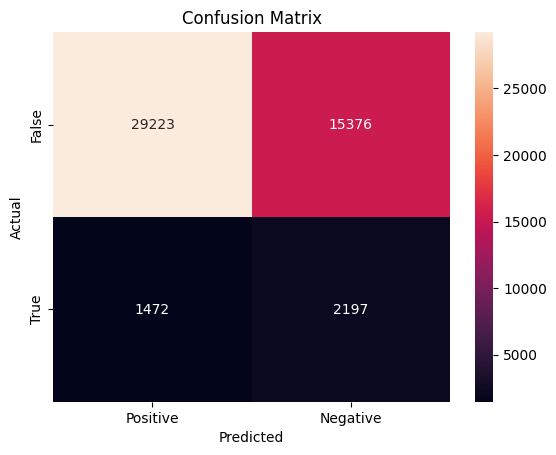

In [41]:
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Positive', 'Negative'], 
            yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.65
Precision: 0.13
Recall: 0.60


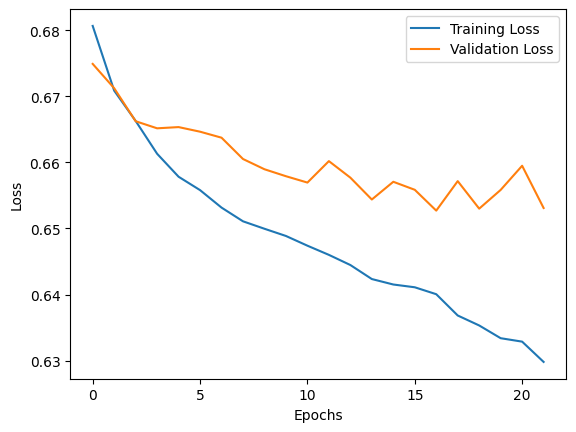

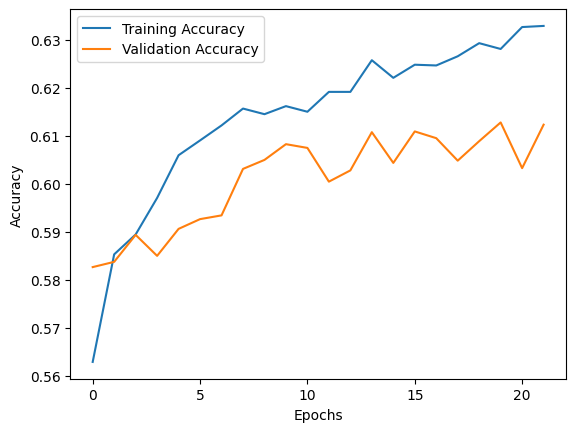

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import os
# Create a 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)
# Save the model
save_model(model, 'models/sepsis_model.h5')

## Trying to improve the LSTM

In [54]:
"""from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.regularizers import l2

model2 = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True, 
         kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    LSTM(32, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])"""

"from keras.layers import LSTM, Dropout, Dense, BatchNormalization\nfrom keras.regularizers import l2\n\nmodel2 = Sequential([\n    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True, \n         kernel_regularizer=l2(0.001)),\n    Dropout(0.3),\n    LSTM(32, kernel_regularizer=l2(0.001)),\n    Dropout(0.3),\n    BatchNormalization(),\n    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),\n    Dense(1, activation='sigmoid')\n])"

## Federico's suggestion to improve the model

In [ ]:
"""def init_model(X_train, y_train):
    # adam = optimizers.Adam(learning_rate=0.02)
    initial_learning_rate = 0.001 # Default Adam

    # lr_schedule = ExponentialDecay(
    # initial_learning_rate,
    # decay_steps = 10000,    # every 500 iterations
    # decay_rate = 0.9)      # we multiply the learning rate by the decay_rate

    # adam = optimizers.Adam(learning_rate=lr_schedule)
    adam = optimizers.Adam()
    reg_l2 = regularizers.L2(0.05)
    output_length = y_train.shape[-1]
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.LSTM(400,
                          activation='tanh',
                          return_sequences = True
                          ))
    model.add(layers.LSTM(100,
                          activation='tanh',
                          return_sequences = True
                          ))
    # model.add(layers.LSTM(128,
    #                       activation='tanh',
    #                       return_sequences = True, #kernel_regularizer = reg_l2
    #                       ))
    # model.add(layers.LSTM(64,
    #                       activation='tanh',
    #                       return_sequences = True, #kernel_regularizer = reg_l2
    #                       ))
    model.add(layers.LSTM(50,
                          activation='tanh',
                          return_sequences = False, #kernel_regularizer = reg_l2
                          ))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(100, activation='relu'
                           ))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(50, activation='relu'
                           ))
    model.add(layers.Dense(output_length, activation='linear'))
    model.compile(loss= 'mse', optimizer=adam, metrics=["mse",'mae']) , # 'mape',smape
    return model

def fit_model(model: tf.keras.Model, verbose=1) -> tuple[tf.keras.Model, dict]:
    es = EarlyStopping(monitor = "val_loss",
                      patience = 150,
                      mode = "min",
                      restore_best_weights = True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          #   patience=30, min_lr=0.000001)
    history = model.fit(X_train, y_train,
                        validation_split = 0.2,
                        shuffle = False,
                        batch_size = 64,
                        epochs = 1000,
                        callbacks = [es],
                        verbose = verbose)
    return model2, history"""

# Random Forest Classifier

## Test splitting

In [50]:
# train test split for the imputed output
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2)

## Building the Model

In [51]:
# random forest classifier
# random forest classifier was tested on different hyper parameters and it gave the best results with number of estimators as 300
#model = RandomForestClassifier(n_estimators=100, random_state=0)
#model = RandomForestClassifier(n_estimators=200, random_state=0)
model2 = RandomForestClassifier(n_estimators=300, random_state=0)
model2.fit(X_train1, y_train1)
rcf_predictions = model2.predict(X_test1)

In [52]:
def evaluate_model(y_true,y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred)
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred)
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC-ROC:", auc)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

Accuracy: 0.9308615049073065
Precision: 0.9409395973154362
Recall: 0.15713965478592243
F1 Score: 0.26930464848252017
AUC-ROC: 0.5781346922043697
Mean Absolute Error: 0.06913849509269357
Root Mean Squared Error: 0.2629419994840945


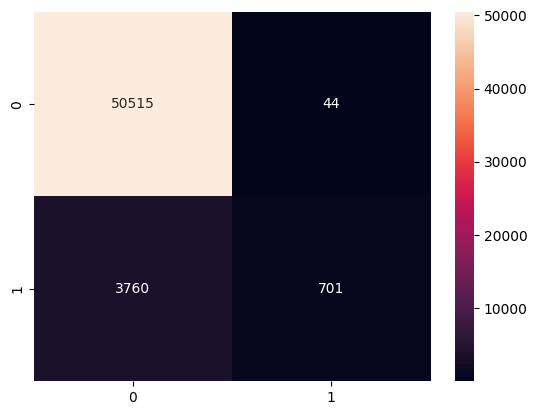

In [53]:
evaluate_model(y_test1, rcf_predictions)